In [48]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point.

In [ ]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH.
!python -m pip install torch==1.0.0


In [49]:
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.1.0+cu121
True


In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as _FormatStrFormatter
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models as _models
import torchvision.models as _models
from PIL import Image
import json
from collections import OrderedDict as _OrderedDict
import torchvision
from torchvision import models
import cv2

from google.colab import files
from io import BytesIO
import os
import json
import zipfile



In [ ]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2024-01-01 21:30:28--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.133.240, 52.217.113.72, 52.217.90.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.133.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  84.8MB/s    in 4.0s    

2024-01-01 21:30:32 (82.2 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

unlink: cannot unlink 'flowers': No such file or directory


In [ ]:
# Upload 'flowers' dataset zip file and 'cat_to_name.json' file
uploaded = files.upload()

# Unzip the 'flowers' dataset
for file_name in uploaded.keys():
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(BytesIO(uploaded[file_name]), 'r') as zip_ref:
            zip_ref.extractall()
            # Assuming 'flowers.zip' contains a root folder named 'flowers'
            root_folder_name = zip_ref.namelist()[0]
            os.rename(root_folder_name, 'flowers')

# Load the 'cat_to_name.json' file
cat_to_name_path = 'cat_to_name.json'
with open(cat_to_name_path, 'r') as f:
    cat_to_name = json.load(f)

# Adjust file paths
data_dir = 'flowers'
valid_dir = os.path.join(data_dir, 'valid')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

Saving Flowers.png to Flowers (1).png
Saving cat_to_name.json to cat_to_name (1).json


In [51]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the common normalization parameters
normalize_params = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Define the transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*normalize_params)
])

test_transforms = valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(*normalize_params)
])

# Load the datasets with ImageFolder
train_data = ImageFolder(train_dir, transform=train_transforms)
test_data = ImageFolder(test_dir, transform=test_transforms)
valid_data = ImageFolder(valid_dir, transform=valid_transforms)

# Define the dataloaders
def create_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Using the image datasets and the transforms, define the dataloaders
batch_size = 64
trainloader = create_dataloader(train_data, batch_size)
testloader = create_dataloader(test_data, batch_size)
validloader = create_dataloader(valid_data, batch_size)


In [52]:

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


In [53]:


def nn_setup(structure='vgg16', lr=0.001):
    # Load the pretrained model
    model = models.vgg16(pretrained=True)

    # Freeze parameters to avoid backpropagation
    for param in model.parameters():
        param.requires_grad = False

    # Modify the classifier
    classifier = nn.Sequential(
        nn.Linear(25088, 2048),
        nn.ReLU(),
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, 102),
        nn.LogSoftmax(dim=1)
    )
    model.classifier = classifier

    # Move the model to GPU
    model = model.to('cuda')

    # Define the criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    return model, criterion, optimizer


In [54]:
# Assuming you have the nn_setup function defined as mentioned earlier

model, criterion, optimizer = nn_setup()

# Print the modified classifier
print("Modified Classifier:")
print(model.classifier)

# Print the entire model
print("\nFull Model:")
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modified Classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=102, bias=True)
  (5): LogSoftmax(dim=1)
)

Full Model:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=T

In [55]:
num_epochs = 3
print_interval = 5
total_steps = 0
loss_history = []

for epoch in range(num_epochs):
    running_loss = 0

    for inputs, labels in trainloader:
        total_steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if total_steps % print_interval == 0:
            model.eval()
            validation_loss = 0
            accuracy = 0

            with torch.no_grad():
                for val_inputs, val_labels in validloader:
                    val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')

                    log_ps = model(val_inputs)
                    batch_loss = criterion(log_ps, val_labels)
                    validation_loss += batch_loss.item()

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == val_labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Training Loss: {running_loss / print_interval:.3f}, "
                  f"Validation Loss: {validation_loss / len(validloader):.3f}, "
                  f"Validation Accuracy: {accuracy / len(validloader):.3f}")

            running_loss = 0
            model.train()


Epoch 1/3, Training Loss: 4.887, Validation Loss: 4.419, Validation Accuracy: 0.087
Epoch 1/3, Training Loss: 4.355, Validation Loss: 4.170, Validation Accuracy: 0.109
Epoch 1/3, Training Loss: 4.086, Validation Loss: 3.755, Validation Accuracy: 0.189
Epoch 1/3, Training Loss: 3.696, Validation Loss: 3.496, Validation Accuracy: 0.278
Epoch 1/3, Training Loss: 3.467, Validation Loss: 3.106, Validation Accuracy: 0.331
Epoch 1/3, Training Loss: 3.178, Validation Loss: 2.838, Validation Accuracy: 0.388
Epoch 1/3, Training Loss: 3.044, Validation Loss: 2.511, Validation Accuracy: 0.430
Epoch 1/3, Training Loss: 2.862, Validation Loss: 2.403, Validation Accuracy: 0.415
Epoch 1/3, Training Loss: 2.436, Validation Loss: 1.986, Validation Accuracy: 0.517
Epoch 1/3, Training Loss: 2.285, Validation Loss: 1.795, Validation Accuracy: 0.563
Epoch 1/3, Training Loss: 2.175, Validation Loss: 1.656, Validation Accuracy: 0.585
Epoch 1/3, Training Loss: 2.089, Validation Loss: 1.594, Validation Accuracy

In [56]:
# TODO: Do validation on the test set
evaluation_loss = 0
test_accuracy = 0

model.to('cuda')

with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')

        logits = model(test_inputs)
        batch_loss = criterion(logits, test_labels)
        evaluation_loss += batch_loss.item()

        probabilities = torch.exp(logits)
        top_probabilities, top_classes = probabilities.topk(1, dim=1)
        correct_predictions = top_classes == test_labels.view(*top_classes.shape)
        test_accuracy += torch.mean(correct_predictions.type(torch.FloatTensor)).item()

print(f"Test Set Accuracy: {test_accuracy / len(testloader):.4f}")
print(f"Average Test Loss: {evaluation_loss / len(testloader):.4f}")


Test Set Accuracy: 0.8278
Average Test Loss: 0.5585


In [57]:
# TODO: Save the checkpoint
# Create a dictionary to store checkpoint information
checkpoint = {
    'input_size': 25088,
    'output_size': 102,
    'structure': 'vgg16',
    'learning_rate': 0.001,
    'classifier': model.classifier,
    'epochs': num_epochs,
    'optimizer': optimizer.state_dict(),
    'state_dict': model.state_dict(),
    'class_to_idx': train_data.class_to_idx
}

# Save the checkpoint to a file
torch.save(checkpoint, 'my_model_checkpoint.pth')


In [58]:
def load_and_rebuild_model(checkpoint_path):
    saved_checkpoint = torch.load(checkpoint_path)

    # Build a new model with the specified structure
    rebuilt_model, _, _ = nn_setup(structure=saved_checkpoint['structure'])

    # Load the model state and class_to_idx from the checkpoint
    rebuilt_model.load_state_dict(saved_checkpoint['state_dict'])
    rebuilt_model.class_to_idx = saved_checkpoint['class_to_idx']

    return rebuilt_model



In [59]:
# Assuming you have the load_and_rebuild_model function defined as mentioned earlier

loaded_model = load_and_rebuild_model('my_model_checkpoint.pth')
print(loaded_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [60]:

def process_image(image_path):

    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))

    # Center crop the image
    center_crop_size = 224
    height, width = img.shape[:2]
    start_y = (height - center_crop_size) // 2
    start_x = (width - center_crop_size) // 2
    img = img[start_y:start_y+center_crop_size, start_x:start_x+center_crop_size]

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize the pixel values
    img = img / 255.0
    # Standardize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std
    # Transpose to PyTorch format (C, H, W)
    img = np.transpose(img, (2, 0, 1))
    # Convert to PyTorch tensor
    img = torch.tensor(img, dtype=torch.float32)

    return img


In [61]:


def imshow(image, ax=None, title=None):
    """Custom Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image_np = image.cpu().numpy()
    image_np = image_np.transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean

    image_np = np.clip(image_np, 0, 1)

    ax.imshow(image_np)

    # Set title if provided
    if title:
        ax.set_title(title)

    return ax


In [62]:


def predict(image_path, model, top_k=5):
    model.eval()

    with torch.no_grad():
        # Process the image and convert to a PyTorch tensor
        image = process_image(image_path)
        image_tensor = image.unsqueeze(0).to('cuda')

        # Perform the forward pass and get the probabilities
        log_probs = model(image_tensor)

        # Calculate the probabilities and top classes
        probabilities = torch.exp(log_probs).cpu().numpy()[0]
        top_classes = np.argsort(-probabilities)[:top_k]

    return probabilities[top_classes], top_classes


In [ ]:
image_path = "flowers/test/10/image_07090.jpg"
probs, classes = predict(image_path, model)
print (probs)
print (classes)

[0.8927595  0.05459247 0.04280715 0.00748502 0.00143431]
[ 1  8 94 24  6]


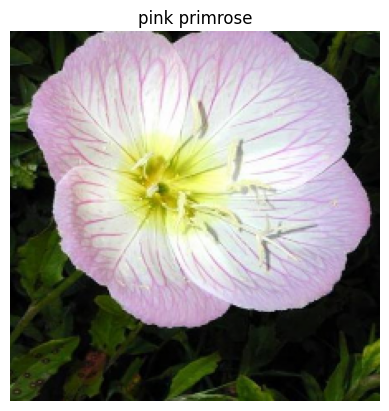

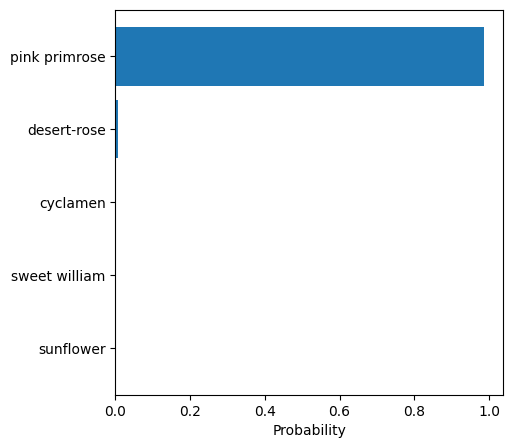

In [63]:

# TODO: Display an image along with the top 5 classes
plt.rcdefaults()
fig, ax = plt.subplots()

index = 1
path = test_dir + '/1/image_06743.jpg'
ps = predict(path, model)
image = process_image(path)

ax1 = imshow(image, ax=ax)  # Fix the function name to imshow and pass 'ax' directly
ax1.axis('off')
ax1.set_title(cat_to_name[str(index)])

# Extracting the top classes correctly
a = np.array(ps[0])
b = [cat_to_name[str(index + 1)] for index in np.array(ps[1])]

fig, ax2 = plt.subplots(figsize=(5, 5))

y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(b)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, a)

plt.show()






In [69]:
import os
import shutil

# Specify the directory path where the .pth files are located in Colab
directory_path = '/content'

# Specify the temporary directory path where you want to move the .pth files
temp_directory_path = '/content/temp'

# Create the temporary directory if it doesn't exist
if not os.path.exists(temp_directory_path):
    os.makedirs(temp_directory_path)

# Get the list of all files in the directory
file_list = os.listdir(directory_path)

# Iterate over each file in the directory
for file_name in file_list:
    if file_name.endswith('.pth'):
        # Construct the full file path
        file_path = os.path.join(directory_path, file_name)

        # Construct the destination file path in the temporary directory
        dest_file_path = os.path.join(temp_directory_path, file_name)

        # Check if the file with the same name already exists in the destination
        if os.path.exists(dest_file_path):
            # Append a unique identifier to the filename
            base, ext = os.path.splitext(file_name)
            dest_file_path = os.path.join(temp_directory_path, f"{base}_duplicate{ext}")

        # Move the file to the temporary directory
        shutil.move(file_path, dest_file_path)


In [ ]:
!jupyter nbconvert --to html Image_Classifier_Project.ipynb

[NbConvertApp] Converting notebook Image_Classifier_Project.ipynb to html
[NbConvertApp] Writing 977010 bytes to Image_Classifier_Project.html


# New Section